# Einlesen der FACT Daten


Die Daten sind im HDF5 Format gespeichert und können mit dem Python-Modul h5py eingelesen werden.

Das Python-Modul `pyfact` bietet eine nützliche Funktion, um diese Daten direkt in ein `pandas.DataFrame` einzulesen.

```
$ pip install pyfact
```

In [32]:
from fact.io import read_h5py
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Einlesen mit h5py

In [33]:
f = h5py.File('../data/open_crab_sample_dl3.hdf5')

print('Tables:')
print(*f)

print()
print('Columns in events table')
print(*f['events'])

print()
print('Columns in runs table')
print(*f['runs'])
f.close()

Tables:
events runs

Columns in events table
dec_prediction disp_prediction event_num gamma_energy_prediction gamma_prediction index night pointing_position_az pointing_position_zd ra_prediction run_id theta_deg theta_deg_off_1 theta_deg_off_2 theta_deg_off_3 theta_deg_off_4 theta_deg_off_5 timestamp

Columns in runs table
azimuth declination index night ontime right_ascension run_id run_start run_stop source zenith


In [34]:
#theta_deg = f['events/theta_deg'][:]

#plt.hist(theta_deg**2, bins=30, range=[0, 0.1])
#None

## Daten einlesen mit pyfact

In [35]:
gammas = read_h5py('../data/gamma_test_dl3.hdf5', key='events', columns=[
    'gamma_energy_prediction',
    'gamma_prediction',
    'theta_deg',
    'corsika_event_header_event_number',
    'corsika_event_header_total_energy',
])
#Testdatensatz aus simulierten Daten


gammas_corsika = read_h5py(
    '../data/gamma_corsika_events_1.1.2.hdf5',
    key='corsika_events',
    columns=['total_energy'],
)
# Infos über simulierten Daten


crab_events = read_h5py('../data/open_crab_sample_dl3.hdf5', key='events', columns=[
    'gamma_prediction',
    'gamma_energy_prediction',
    'theta_deg',
    'theta_deg_off_1',
    'theta_deg_off_2',
    'theta_deg_off_3',
    'theta_deg_off_4',
    'theta_deg_off_5',
])
#Messdaten

crab_runs = read_h5py('../data/open_crab_sample_dl3.hdf5', key='runs')

In [36]:
#crab_events.head()

# Limits für theata^2 - Plot

In [37]:
limit_theta = np.sqrt(0.025)
crab_events_pred = crab_events[crab_events.gamma_prediction>0.8]
crab_events_sel = crab_events_pred[crab_events_pred.theta_deg<limit_theta]

gammas_pred = gammas[gammas.gamma_prediction>0.8]
gammas_sel = gammas_pred[gammas_pred.theta_deg < limit_theta]

In [38]:
# Mit diesem limit werden alle events für den theta^2 plot ausgewählt (theta^2 < 0.3)
# Für Berechnungen weiterhin crab_events_sel bzw bkg verwenden
limit_theta_plot = np.sqrt(0.3)
crab_events_pred_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta_plot]
crab_events_pred_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta_plot]
crab_events_pred_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta_plot]
crab_events_pred_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta_plot]
crab_events_pred_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta_plot]

crab_events_sel_plot= crab_events_pred[crab_events_pred.theta_deg < limit_theta_plot]

In [39]:
crab_events_sel_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta]
crab_events_sel_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta]
crab_events_sel_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta]
crab_events_sel_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta]
crab_events_sel_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta]
# mask = (crab_events_pred.theta_deg_off_1 < limit_theta) | (crab_events_pred.theta_deg_off_2 < limit_theta) | (crab_events_pred.theta_deg_off_3 < limit_theta) | (crab_events_pred.theta_deg_off_4 < limit_theta) | (crab_events_pred.theta_deg_off_5 < limit_theta)
# crab_events_sel_all = crab_events_pred[mask]
bkg = pd.concat([crab_events_sel_1, crab_events_sel_2, crab_events_sel_3, crab_events_sel_4, crab_events_sel_5])

# Histogramm der Abstandswinkel

In [40]:
theta_deg_off = []
for i in [1, 2, 3, 4, 5]:
    exec('x = crab_events_pred_{}.theta_deg_off_{}.values'.format(i, i))
    for el in x:
        theta_deg_off.append(el)

250


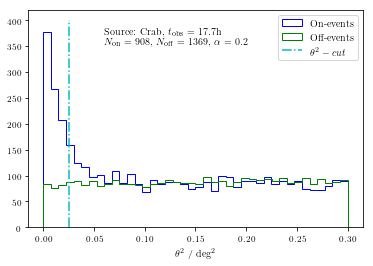

In [41]:
crab_events_sel_on = np.array(crab_events_sel_plot.theta_deg.values)
plt.hist((crab_events_sel_on)**2, bins =40, histtype='step', color='blue', label='On-events')

plt.hist(np.array(theta_deg_off)**2, bins=40, histtype='step', color='g', label='Off-events', weights=np.array([0.2 for el in theta_deg_off]))
plt.vlines(0.025, color='c', linestyle='-.', ymin=0, ymax=400, label=r'$\theta^{2}-cut$')
plt.xlabel(r'$\theta^2$ / $\deg^2$')
plt.legend()
plt.text(0.06, 350,
         r'''Source: Crab, $t_\mathrm{{obs}}$ = 17.7h
        $N_\mathrm{{on}}$ = {non}, $N_\mathrm{{off}}$ = {noff}, $\alpha$ = 0.2'''.format(non=len(crab_events_sel), noff=len(bkg)))

print(len(crab_events_sel_1.theta_deg_off_1.values))

# 2D-Scatterplot der Energien

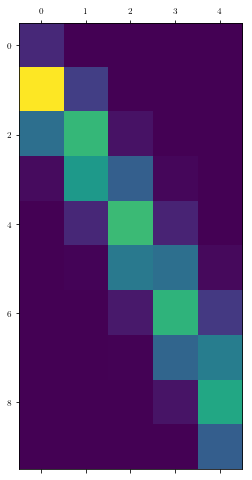

In [49]:
matrix, xedge, yedge = np.histogram2d(
    gammas_sel['gamma_energy_prediction'],
    gammas_sel['corsika_event_header_total_energy'], 
                                         bins=[
                                             np.logspace(np.log10(500),np.log10(20e3),11),
                                             np.logspace(np.log10(500),np.log10(20e3),6),
                                         ])
matrix = matrix/np.sum(matrix,axis=0) #hier erfolgt die Normierung
plt.matshow(matrix)

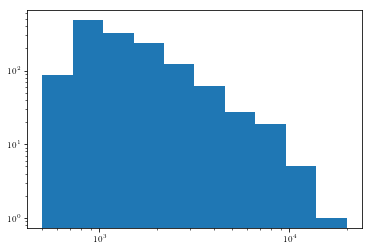

In [50]:
# Untergrund binnen
b, bins, p = plt.hist(bkg['gamma_energy_prediction'], bins=xedge)
plt.xscale('log')
plt.yscale('log')

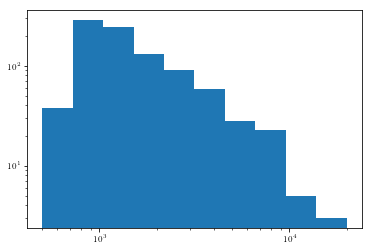

In [51]:
# Signal binnen
g, bins, p = plt.hist(crab_events_sel['gamma_energy_prediction'], bins=xedge)
plt.xscale('log')
plt.yscale('log')

In [52]:
# Penrose-Moore Pseudoinverse ausrechnen (nicht quadratisch)
inv = np.linalg.pinv(matrix)
print(inv)

[[ 0.200252    1.54175129 -0.09980618 -0.44030576  0.13998219  0.1043457
  -0.05730653 -0.02417532  0.021076    0.01389095]
 [-0.12446809 -0.58286629  1.53701266  1.21829017 -0.47814937 -0.32323891
   0.18347502  0.07655227 -0.0673411  -0.04431417]
 [ 0.04397607  0.1812815  -0.54517021  0.22624544  1.79137323  0.72798733
  -0.59232565 -0.22321857  0.21526672  0.13951504]
 [-0.01541343 -0.06231219  0.18844386 -0.11045215 -0.54423452  0.6534628
   1.86449025  0.48381383 -0.67693771 -0.41747548]
 [ 0.00517715  0.02083784 -0.06310303  0.03876491  0.17457175 -0.25450012
  -0.41265717  0.77303205  1.6749298   0.86431206]]


Unfolded: [-264.58448609 -114.81882932  -78.13491514   26.83183495   -3.37603662]
 shape (5,)


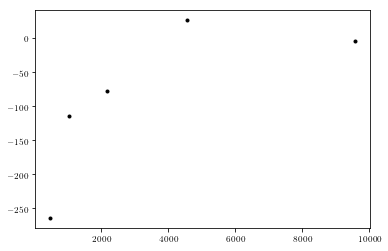

In [53]:
# Naive Entfaltung
ev = g-b
print('Unfolded: {}\n shape {}'.format(inv.dot(ev), np.shape(inv.dot(ev))))
plt.plot(yedge[:-1], inv.dot(ev), 'k.')

[ 2324.         26813.         34302.         28137.
 19614.06532517 11718.96354622  6948.14056576  3586.64537766
  1801.19422572   701.99095946]


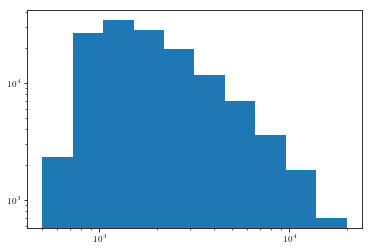

In [54]:
#Entfaltung mit Likelihood-Fit
f, bins = np.histogram(gammas_sel['corsika_event_header_total_energy'], bins=yedge)
b, bins = np.histogram(bkg['gamma_energy_prediction'], bins=xedge)
lam = matrix@f-b
bincenter = (bins[:-1]+bins[1:])/2
plt.hist(bincenter, bins=bins, weights=lam)
plt.xscale('log')
plt.yscale('log')
print(lam)

In [ ]:
likelihood = 